In [1]:
import pickle
import joblib
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import numpy as np
# Daten laden
with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load(f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load(f)
with open('short_train_df.pkl', 'rb') as f:
    short_train_df = pickle.load(f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)
with open('short_test_df.pkl', 'rb') as f:
    short_test_df = pickle.load(f)
min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

c:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Python 3.12\venvMasterarbeit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


14:51:58 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing


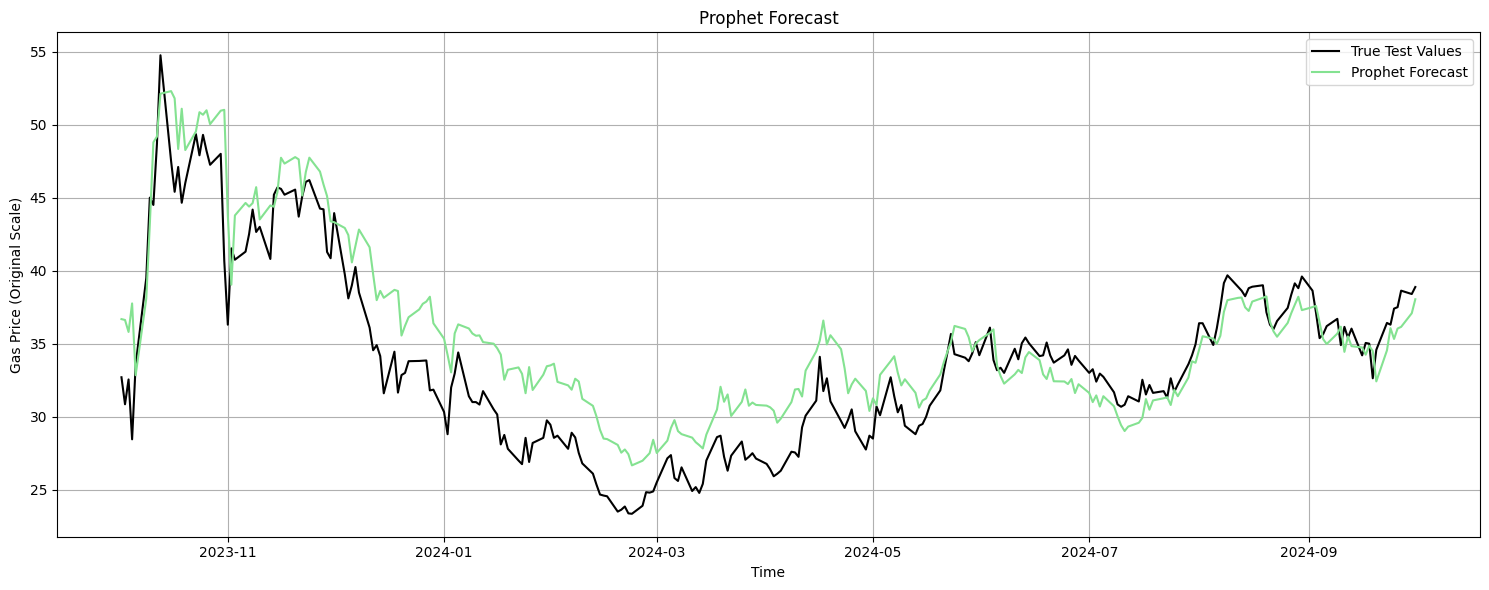

MAE: 2.5595
RMSE: 9.6731
R²: 0.7449


In [5]:


# --- Feature-Liste ---
selected_features_cb = ['S-Gas DA D','N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']
# --- Trainingsdaten für Prophet ---
train_prophet_df = train_y_df.copy()
train_prophet_df.columns = ['y']
train_prophet_df['ds'] = train_prophet_df.index
train_prophet_df = train_prophet_df[['ds', 'y']].join(train_df[selected_features_cb])

# --- Prophet-Modell mit Regressoren ---
model = Prophet(seasonality_mode='multiplicative')
for feature in selected_features_cb:
    model.add_regressor(feature)

model.fit(train_prophet_df)

# --- Testdaten vorbereiten ---
future = test_y_df.copy()
future['ds'] = future.index
future = future[['ds']].join(test_df[selected_features_cb].fillna(0))

# --- Vorhersage ---
forecast = model.predict(future)

# --- Rückskalierung ---
y_pred_rescaled = y_min_max_scaler.inverse_transform(forecast[['yhat']].values).flatten()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).flatten()

# --- Visualisierung ---
plt.figure(figsize=(15, 6))

plt.plot(test_y_df.index, y_holdout_rescaled, label='True Test Values', color='black')
plt.plot(forecast['ds'], y_pred_rescaled, label='Prophet Forecast', color='#84E291')
#plt.fill_between(forecast['ds'],
                # y_min_max_scaler.inverse_transform(forecast[['yhat_lower']].values).flatten(),
                # y_min_max_scaler.inverse_transform(forecast[['yhat_upper']].values).flatten(),
                # color='lightgrey', alpha=0.3, label='Forecast Uncertainty')
plt.title('Prophet Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price (Original Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Bewertung ---
mae = mean_absolute_error(y_holdout_rescaled, y_pred_rescaled)
rmse = mean_squared_error(y_holdout_rescaled, y_pred_rescaled)
r2 = r2_score(y_holdout_rescaled, y_pred_rescaled)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")




In [6]:
import numpy as np
import pandas as pd

# --- Regressor-Koeffizienten extrahieren (wie bei dir schon angelegt) ---
def regressor_index(m, name):
    return list(m.extra_regressors.keys()).index(name)

def regressor_coefficients(m):
    assert len(m.extra_regressors) > 0, 'No extra regressors found.'
    coefs = []
    for regressor, params in m.extra_regressors.items():
        beta = m.params['beta'][:, regressor_index(m, regressor)]
        if params['mode'] == 'additive':
            coef = beta * m.y_scale / params['std']
        else:
            coef = beta / params['std']
        percentiles = [
            (1 - m.interval_width) / 2,
            1 - (1 - m.interval_width) / 2,
        ]
        coef_bounds = np.quantile(coef, q=percentiles)
        record = {
            'type': 'regressor',
            'component': regressor,
            'regressor_mode': params['mode'],
            'center': params['mu'],
            'coef_lower': coef_bounds[0],
            'coef': np.mean(coef),
            'coef_upper': coef_bounds[1],
        }
        coefs.append(record)
    return pd.DataFrame(coefs)

# --- Zeitabhängige Komponenten aus forecast ---
def extract_components_from_forecast(forecast):
    cols = [c for c in forecast.columns if c in [
        'trend',
        'seasonal',
        'seasonal_weekly',
        'seasonal_yearly',
        'holidays'
    ]]
    component_means = []
    for col in cols:
        values = forecast[col]
        record = {
            'type': 'component',
            'component': col,
            'coef': np.mean(values),
            'coef_lower': np.min(values),
            'coef_upper': np.max(values),
            'center': np.nan,
            'regressor_mode': None
        }
        component_means.append(record)
    return pd.DataFrame(component_means)

# --- Combine and export feature importance summary ---
coef_df = regressor_coefficients(model)
comp_df = extract_components_from_forecast(forecast)
importance_df = pd.concat([coef_df, comp_df], ignore_index=True)

# --- Sort by absolute impact ---
importance_df['abs_coef'] = np.abs(importance_df['coef'])
importance_df_sorted = importance_df.sort_values(by='abs_coef', ascending=False).drop(columns='abs_coef')

# --- Ausgabe ---
print(importance_df_sorted.round(4).to_csv(sep=';', index=False))


type;component;regressor_mode;center;coef_lower;coef;coef_upper
regressor;P-GPR_rollmean_30;multiplicative;0.222;6.1;6.1;6.1
regressor;S-Gas DA D;multiplicative;0.2444;-3.7916;-3.7916;-3.7916
regressor;K-Wind speed_rollmean_7;multiplicative;0.3044;3.6772;3.6772;3.6772
regressor;N-Demand LDZ_rollmean_30;multiplicative;0.4628;1.7623;1.7623;1.7623
regressor;S-Coal Price (close)_rollmean_7;multiplicative;0.3561;0.717;0.717;0.717
regressor;P-European_News_Index_rollmean_30;multiplicative;0.4185;0.5998;0.5998;0.5998
regressor;S-Coal Price (close)_lag1;multiplicative;0.3403;-0.4182;-0.4182;-0.4182
regressor;Season_Winter;multiplicative;0.0;-0.2301;-0.2301;-0.2301
component;trend;;;0.1236;0.1304;0.1371
regressor;P-GPR_lag1;multiplicative;0.1968;-0.033;-0.033;-0.033
regressor;S-Coal Price (close)_rollstd_3;multiplicative;0.1095;-0.0184;-0.0184;-0.0184
regressor;N-Demand LDZ_rollstd_30;multiplicative;0.4209;-0.0154;-0.0154;-0.0154
regressor;P-European_News_Index_lag1;multiplicative;0.4774;0.0028